# İş Akışı ve Hiperparametre Optimizasyonu

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np

🏠 Ev fiyatları veri setini içe aktarın. Basitlik adına sadece sayısal özellikleri tutacağız

🎯 Hedefiniz en iyi KNN Regressor'ı yerleştirmek olacak. Özellikle, ev fiyatlarınız için en iyi tahminleri elde etmek üzere kaç tane "komşu" (<font color=blue>K</font>NN'deki <font color=blue>K</font>) göz önünde bulundurmalısınız?

In [2]:
# Load raw data
data = pd.read_csv('https://d32aokrjazspmn.cloudfront.net/materials/houses_train_raw.csv', index_col="Id")

# Only keep numerical columns and raws without NaN
data = data.select_dtypes(include=np.number).dropna()

data

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
1,60,65.0,8450,7,5,2003,2003,196.0,706,0,...,0,61,0,0,0,0,0,2,2008,208500
2,20,80.0,9600,6,8,1976,1976,0.0,978,0,...,298,0,0,0,0,0,0,5,2007,181500
3,60,68.0,11250,7,5,2001,2002,162.0,486,0,...,0,42,0,0,0,0,0,9,2008,223500
4,70,60.0,9550,7,5,1915,1970,0.0,216,0,...,0,35,272,0,0,0,0,2,2006,140000
5,60,84.0,14260,8,5,2000,2000,350.0,655,0,...,192,84,0,0,0,0,0,12,2008,250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1456,60,62.0,7917,6,5,1999,2000,0.0,0,0,...,0,40,0,0,0,0,0,8,2007,175000
1457,20,85.0,13175,6,6,1978,1988,119.0,790,163,...,349,0,0,0,0,0,0,2,2010,210000
1458,70,66.0,9042,7,9,1941,2006,0.0,275,0,...,0,60,0,0,0,0,2500,5,2010,266500


In [3]:
X = data.drop(columns=['SalePrice'])
y = data['SalePrice']

## 1. Eğitim/Test Ayrımı

❓ **Soru (Holdout)**❓

👇 `X_train`, `X_test`, `y_train` ve `y_test` oluşturmak için veri setini böl. Şunları kullan:
- `test_size=0.3`
- Sonuçlarınızı arkadaşınızla karşılaştırmak için `random_state=0`

In [4]:
from sklearn.model_selection import train_test_split
X_train, X_test,y_train,y_test =train_test_split(X,y,test_size=0.3,random_state=0)

## 2. Ölçeklendirme

⚖️ Ölçeklendirme KNN algoritması için her zaman kritik derecede önemlidir..

❓ **Soru (Ölçeklendirme)** ❓ 

* Eğitim setinizi ve test setinizi ölçeklendirin.
* Burada, basitçe `StandardScaler` uygulayalım ve özellik başına bir ölçekleyici seçerek zaman kaybetmeyelim. Gerçekten de, bu egzersizin amaçları şunlardır:
    * KNN'i gözden geçirmek
    * GridSearchCV'yi anlamak
    * RandomizedSearchCV'yi anlamak

In [8]:
from sklearn.preprocessing import StandardScaler
scaler=StandardScaler()

X_train_scaled=pd.DataFrame(scaler.fit_transform(X_train)
                           ,columns=X_train.columns,
                           index=X_train.index)


## 3. Temel KNN modeli

❓ **Soru (KNN için bir temel)** ❓

Sadece _en yakın komşuyu_ dikkate alan basit bir KNN regressor'ı çapraz doğrulayın (*cv = 5*) ve 5 kat üzerindeki ortalama skoru hesaplayın.

In [12]:
from sklearn.neighbors import KNeighborsRegressor

from sklearn.model_selection import cross_validate

knn=KNeighborsRegressor(n_neighbors=1)
cv_result=cross_validate(knn,X_train_scaled,y_train,cv=5)["test_score"].mean()
cv_result


0.5601542887874071

## 4. GridSearch

### 4.1. İlk GridSearch

❓ **Soru (GridSearch v1)**❓

En iyi KNN hiperparametresini `n_neighbors` bulmak için SKLearn `GridSearchCV` kullanalım.
- `n_neighbors` = [1,5,10,20,50] ile kaba taneli bir yaklaşım başlat
- Her parametreyi 5-kat çapraz doğrula
- `n_jobs` kullanarak performans sürenizi maksimize ettiğinizden emin olun

In [16]:
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsRegressor

model=KNeighborsRegressor()

k_grid={'n_neighbors':[1,5,10,20,50]}


grid=GridSearchCV(model,k_grid,n_jobs=-1,cv=5)


grid.fit(X_train_scaled,y_train)



GridSearchCV(cv=5, estimator=KNeighborsRegressor(), n_jobs=-1,
             param_grid={'n_neighbors': [1, 5, 10, 20, 50]})

❓ **Soru (en iyi parametreler)** ❓

GridSearch'e göre, optimal K değeri nedir?

In [17]:
grid.best_params_

{'n_neighbors': 10}

❓ **Soru (puanlama)** ❓ Optimal K değerinin ürettiği en iyi skor nedir?

In [18]:
grid.best_score_

0.7596697382171873

### 4.2. İkinci GridSearch

❓ **Soru (GridSearch V2)** ❓

Şimdi, en iyi $K$'nın nerede olduğu hakkında bir fikrimiz var, ancak denemediğimiz bazı değerler daha iyi bir performansla sonuçlanabilir.

* Önceki en iyi değerinizin çevresindeki $K$ için bazı değerleri deneyerek GridSearch'ü yeniden çalıştırın
* Bu rafine edilmiş GridSearch için `best_score` ve `best_k` nelerdir?

In [22]:
model_fine=KNeighborsRegressor()

k_grid_fine={'n_neighbors':range(5,31)}

grid_fine=GridSearchCV(model_fine,k_grid_fine,cv=5,n_jobs=-1)

grid_fine.fit(X_train_scaled,y_train)
print(f"en iyi k değeri:{grid_fine.best_params_}")

print(f"en iyi score:{grid_fine.best_score_}")

en iyi k değeri:{'n_neighbors': 16}
en iyi score:0.7666311417513013


In [27]:
best_k = grid_fine.best_params_["n_neighbors"]
best_score = grid_fine.best_score_

***🧪 Kodunuzu test edin***

In [28]:
from nbresult import ChallengeResult
result = ChallengeResult('knn',
                         best_k=best_k,
                         best_score=best_score)
result.write()
print(result.check())


============================= test session starts ==============================
platform linux -- Python 3.12.9, pytest-8.3.4, pluggy-1.5.0 -- /home/funny/.pyenv/versions/3.12.9/envs/workintech/bin/python
cachedir: .pytest_cache
rootdir: /home/funny/D16D5-S-data-workflow/tests
plugins: anyio-4.8.0, typeguard-4.4.2
collecting ... collected 2 items

test_knn.py::TestKnn::test_best_k PASSED                                 [ 50%]
test_knn.py::TestKnn::test_best_score PASSED                             [100%]

============================== 2 passed in 0.11s ===============================


💯 You can commit your code:

git add tests/knn.pickle

git commit -m 'Completed knn step'

git push origin master



### 4.3. Görsel kontrol (manuel GridSearch)

☝️ Bu problem aslında manuel olarak GridSearch yapmak için yeterince basittir.

❓ **Soru(Manuel GridSearch)** ❓

- $K$'nın $1$'den $50$'ye kadar tüm değerleri üzerinde manuel olarak döngü yapın ve her modelin çapraz doğrulanmış skorlarının ortalamasını bir listede saklayın.
- `Dirsek Yöntemi` kullanarak en iyi $K$'yı görsel olarak bulmak için skorları $K$'nın bir fonksiyonu olarak çizin

In [30]:
import matplotlib.pyplot as plt
k_values=range(1,51)
scores=[]

for k in k_values:
    model = KNeighborsRegressor(n_neighbors=k)
    cv_results = cross_validate(model, X_train_scaled, y_train, cv=5)
    scores.append(cv_results['test_score'].mean())

ValueError: x and y must have same first dimension, but have shapes (49,) and (50,)

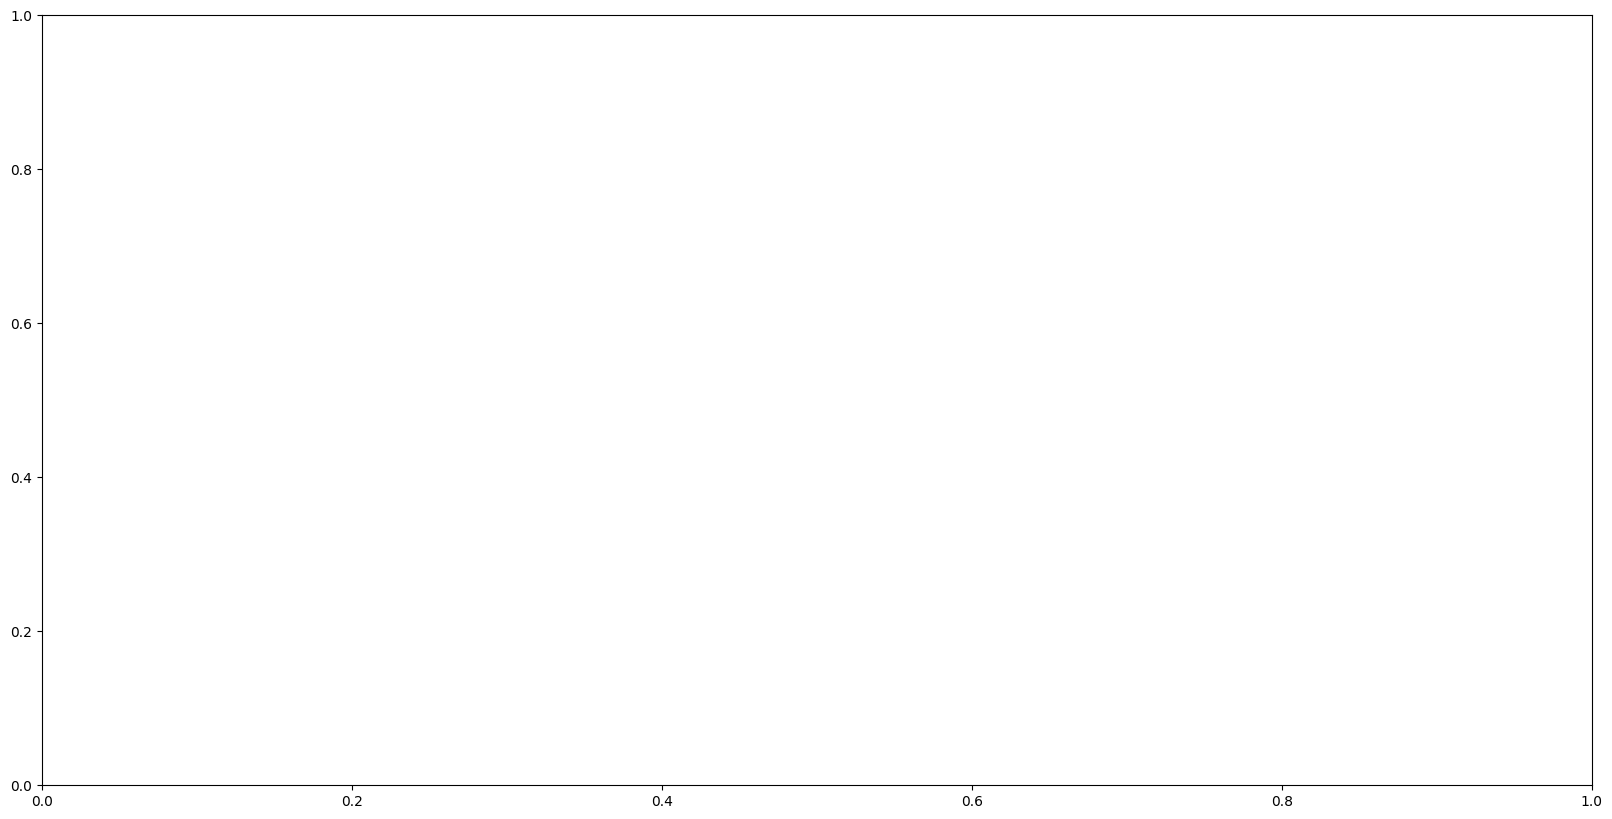

In [34]:
import matplotlib.pyplot as plt

with plt.style.context('fast'):
    # figsize
    plt.figure(figsize=(20,10))
    # getting axes
    ax = plt.gca()
    # plotting
    ax.plot(range(1,50),scores,color='black', linestyle='dashed', marker='o',markerfacecolor='#947FFF', markersize=10)
    # more
    ax.set_title('Score vs. $K$ Neighbors', fontsize = 18)
    ax.set_xlabel('$K$', fontsize = 14)
    ax.set_ylabel('R2 score', fontsize = 14)
    ax.grid(axis="x",linewidth=0.5)
    ax.grid(axis="y",linewidth=0.5)
    # best K
    # focusing
    ax.scatter(7,scores[7-1],c='#00ad8b',s=700)
    ax.scatter(13,scores[13-1],c='#ff6984',s=700)
    
    # annotate
    ax.annotate("Elbow Method", 
                xy=(7,scores[7-1]),
                xytext=(7+0.25,scores[7-1]-0.025), 
                arrowprops=dict(arrowstyle='-|>',
                                fc="k",
                                ec="k",
                                lw=2),
                bbox=dict(pad=5, facecolor="none", edgecolor="none")
               )
    
    ax.annotate("Best K", 
            xy=(13,scores[13-1]),
            xytext=(13+0.25,scores[13-1]-0.025), 
            arrowprops=dict(arrowstyle='-|>',
                            fc="k",
                            ec="k",
                            lw=2),
            bbox=dict(pad=5, facecolor="none", edgecolor="none")
           )

    # spines
    
    
    plt.show()

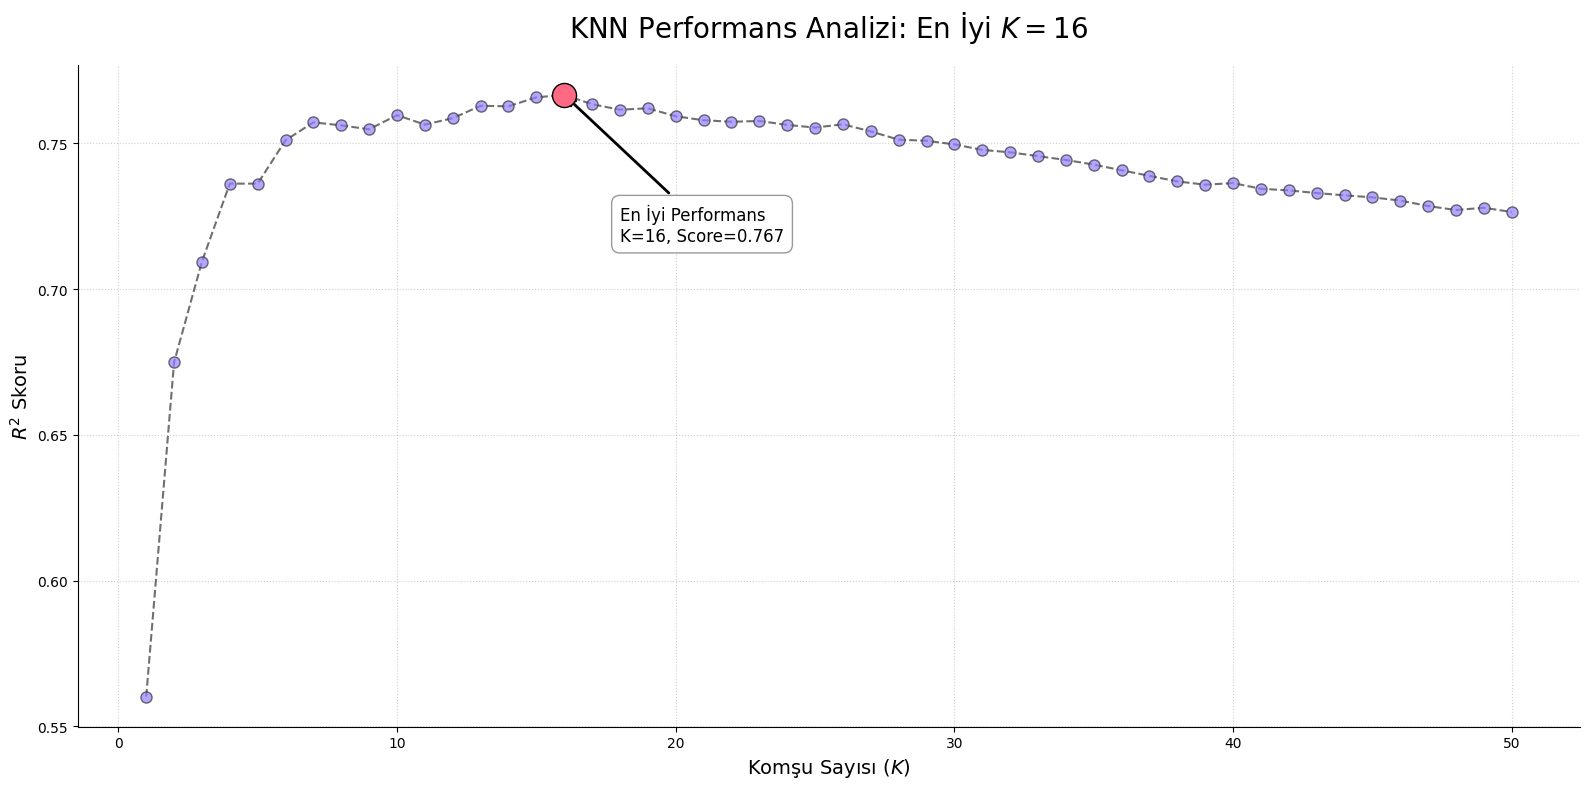

In [32]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import cross_val_score

# 1. Tüm K değerleri için skorları hesapla
k_values = range(1, 51)
scores = []

for k in k_values:
    model = KNeighborsRegressor(n_neighbors=k)
    # cross_val_score doğrudan skor listesini verir
    score = cross_val_score(model, X_train_scaled, y_train, cv=5).mean()
    scores.append(score)

# 2. Dinamik değerleri bul
best_score = max(scores)
best_k = k_values[np.argmax(scores)] # En yüksek skorun olduğu K indexi

# 3. Profesyonel Görselleştirme
with plt.style.context('fast'):
    plt.figure(figsize=(16, 8))
    ax = plt.gca()
    
    # Tüm skorların çizimi
    ax.plot(k_values, scores, color='#333333', linestyle='--', marker='o', 
            markerfacecolor='#947FFF', markersize=8, alpha=0.7, label='R2 Score')
    
    # Başlık ve Etiketler
    ax.set_title(f'KNN Performans Analizi: En İyi $K = {best_k}$', fontsize=20, pad=20)
    ax.set_xlabel('Komşu Sayısı ($K$)', fontsize=14)
    ax.set_ylabel('$R^2$ Skoru', fontsize=14)
    
    # Izgara ayarları (Hafif ve profesyonel görünüm)
    ax.grid(True, linestyle=':', alpha=0.6)
    
    # En İyi K Noktasını İşaretleme (Dinamik)
    ax.scatter(best_k, best_score, c='#ff6984', s=300, edgecolors='black', zorder=5)
    
    # Annotate (Açıklama Ekleme)
    ax.annotate(f"En İyi Performans\nK={best_k}, Score={best_score:.3f}", 
                xy=(best_k, best_score),
                xytext=(best_k + 2, best_score - 0.05), 
                arrowprops=dict(arrowstyle='->', lw=2, color='black'),
                fontsize=12,
                bbox=dict(boxstyle="round,pad=0.5", fc="white", ec="gray", alpha=0.8))

    # Gereksiz çerçeveleri kaldıralım (Spines)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    plt.tight_layout()
    plt.show()

❓GridSearchCV'yi böyle bir manuel döngüden daha iyi bir seçenek yapan şeyi tahmin edebilir misiniz?

<details>
    <summary>Cevap</summary>

- Sklearn'ın `n_jobs=-1` seçeneği aramayı paralelleştirmenize izin verir, tüm CPU çekirdeklerinizi kullanır
- Birlikte optimize edilecek birden fazla hiperparametreniz olsaydı ne olurdu?
</details>

## 5. Birden çok parametre ile GridSearch

👩🏻‍🏫 KNNRegressor, `p` hiperparametresi aracılığıyla çeşitli _mesafe metrikleri_ destekler

📚 [sklearn.neighbors.KNeighborsRegressor](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsRegressor.html)

❓ **Soru (birden çok parametreyi ayarlama)** ❓

* En iyi $K$ ve $p$'yi aynı anda aramak için GridSearchCV kullanın.
    * $K = [1, 5, 10, 20, 50]$ ve $p = [1, 2, 3]$ için tüm kombinasyonları deneyin.

In [38]:
model_p=KNeighborsRegressor()

k_grid={'n_neighbors':[1,5,10,20,50],
        'p':[1,2,3]}

grid=GridSearchCV(model_p,k_grid,n_jobs=-1,cv=5)

grid.fit(X_train_scaled,y_train)

GridSearchCV(cv=5, estimator=KNeighborsRegressor(), n_jobs=-1,
             param_grid={'n_neighbors': [1, 5, 10, 20, 50], 'p': [1, 2, 3]})

❓ **Soru (alt model sayısı)**❓

Toplamda kaç alt model eğittiniz?

<details>
    <summary>İpucu</summary>

15'ten çok daha fazla. İki kez düşün :)
    <details>
    <summary>Cevap</summary>

CV=5 nedeniyle 75 model
</details>

In [39]:
75

75

❓ **Soru (modeli birden çok parametre ile ayarladıktan sonra en iyi parametreler ve en iyi skor)**❓

*En iyi parametreler* ve *en iyi skor* nedir?

In [40]:
print(f"en iyi k değeri:{grid.best_params_}")
print(f"en iyi score:{grid.best_score_}")

en iyi k değeri:{'n_neighbors': 10, 'p': 1}
en iyi score:0.7969255879201194


## 6. Rastgele Arama

Şimdi bir RandomizedSearch'ün aynı sayıda model yerleştirilerek daha iyi bir kombinasyon bulup bulamayacağını görelim.

❓ **Soru (RandomizedSearchCV)** ❓

`RandomizedSearchCV` kullanarak
- $K$'yı uniform `scipy.stats.randint(1,50)` ([döküman](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.randint.html)) dağılımından rastgele örnekle
- $p$'yi $[1,2,3]$ listesinden örnekle
- Önceki GridSearchCV'nizdeki ile tam olarak aynı sayıda model yerleştirmek için doğru `n_iter` ve `cv` sayılarını kullanın.

In [42]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

model_p = KNeighborsRegressor()

search_space = {'n_neighbors': randint(1, 50), 'p': [1, 2, 3]}

search = RandomizedSearchCV(model, param_distributions=search_space,
                            n_jobs=-1,  cv=5, n_iter=15)

search.fit(X_train_scaled, y_train)

print(search.best_score_)
print(search.best_params_)

0.7949980062278728
{'n_neighbors': 7, 'p': 1}


## 7. Genelleme

❓ **Soru (modelinizi bir kez daha ince ayarlama)**❓

- İsterseniz RandomsearchCV'nizi rafine edin
- En iyi modelinizi seçin

In [43]:
best_model = search.best_estimator_

Şimdi `cv_results`'ınızı bir `DataFrame` olarak görüntülemeye çalışın, bu CV'nin içinde neler olup bittiğini görselleştirmenize yardımcı olacak! 😉

In [44]:
pd.DataFrame(search.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_neighbors,param_p,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.002255,0.000101,0.006938,0.001216,26,1,"{'n_neighbors': 26, 'p': 1}",0.770415,0.805646,0.720335,0.814200,0.759170,0.773953,0.033853,4
1,0.002260,0.000120,0.008208,0.001243,45,1,"{'n_neighbors': 45, 'p': 1}",0.752584,0.791376,0.710417,0.779401,0.721395,0.751034,0.031505,6
2,0.004021,0.002675,0.008650,0.003003,7,1,"{'n_neighbors': 7, 'p': 1}",0.736660,0.817465,0.757978,0.867009,0.795878,0.794998,0.045749,1
3,0.002306,0.000175,0.008750,0.002863,24,1,"{'n_neighbors': 24, 'p': 1}",0.768028,0.808209,0.724827,0.818526,0.762317,0.776381,0.033807,3
4,0.002166,0.000189,0.066285,0.005422,46,3,"{'n_neighbors': 46, 'p': 3}",0.700768,0.766950,0.646534,0.735098,0.651915,0.700253,0.046659,15
5,0.002430,0.000977,0.060167,0.001245,17,3,"{'n_neighbors': 17, 'p': 3}",0.725889,0.788035,0.705242,0.776904,0.695673,0.738348,0.037491,9
6,0.001874,0.000022,0.006751,0.000348,47,1,"{'n_neighbors': 47, 'p': 1}",0.746919,0.787939,0.709366,0.775527,0.717408,0.747432,0.030922,8
7,0.002000,0.000079,0.062402,0.003613,35,3,"{'n_neighbors': 35, 'p': 3}",0.708173,0.777706,0.662240,0.751799,0.664366,0.712857,0.046168,13
8,0.003013,0.001335,0.003251,0.000145,18,2,"{'n_neighbors': 18, 'p': 2}",0.732910,0.806902,0.715228,0.824201,0.728414,0.761531,0.044824,5
9,0.002412,0.000544,0.004253,0.000398,45,2,"{'n_neighbors': 45, 'p': 2}",0.732582,0.784430,0.684748,0.759886,0.695648,0.731459,0.037629,11


❓ **Soru ("En iyi" modelin değerlendirmesi)** ❓

* "En iyi parametrelerle" modelimizin **görülmemiş** test seti `X_test` üzerindeki performansını keşfetme zamanı geldi.
    * Test seti için r2 skorunu hesaplayın ve `r2_test` olarak kaydedin.

In [45]:
from sklearn.metrics import r2_score

r2_test = r2_score(y_test, best_model.predict(scaler.transform(X_test)))
r2_test

/home/funny/.pyenv/versions/3.12.9/envs/workintech/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but KNeighborsRegressor was fitted with feature names
  warnings.warn(


0.7690584913149612

❓ **Soru (Bir adım geri çekilme)** ❓

Optimize edilmiş modelin iyi genelleme yaptığını düşünür müsünüz?

<details><summary>Cevap</summary>

Test skoru eğitim seti ile biraz azalabilir. Muhtemelen %5'ten fazla değil. Bunun nedeni şunlar olabilir:
- Temsili olmayan bir eğitim/test bölünmesi
- Model ayarlama aşamasında aşırı öğrenmeye yol açan çok küçük bir çapraz doğrulama sayısı. Ne kadar çok çapraz doğrulama yaparsanız, bulgularınız o kadar güçlü genelleşir - ancak veri setiniz çok küçükse cv'yi çok fazla artıramazsınız çünkü her katmanda temsili olmak için yeterli gözlemi tutamazsınız.
- Veri setimiz çok küçük ve hiperparametre optimizasyonumuz bu nedenle eğitim/test bölünmemize son derece bağımlı (ve aşırı uyum gösteriyor). Veri setinizin denediğiniz toplam hiperparametre kombinasyonu sayısından çok daha büyük olduğundan her zaman emin olun!
    
</details>

***🧪 Kodunuzu test edin***

In [ ]:
from nbresult import ChallengeResult
result = ChallengeResult('r2', 
                         r2_test=r2_test)
result.write()
print(result.check())

🏁 Tebrikler! Artık GridSearchCV veya RandomizedSearchCV kullanarak bir modeli nasıl ince ayarlayacağınızı biliyorsunuz

💾 Notebook'unuzu `git add/commit/push` yapmayı unutmayın...

🚀 ... ve bir sonraki meydan okumaya geçin!